In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [3]:
from ssd_utils.ssd_gen import Generator
from ssd_utils.ssd_box import BBoxUtility, DefaultBox
from ssd_utils.ssd_training import MultiboxLoss

## difinition of folders

In [3]:
FOLDER = '../../../data_kaggle/kuzushiji/'
IMAGES = FOLDER + 'train_images/'
print(os.listdir(FOLDER))

['unicode_translation.csv', 'train_images', 'sample_submission.csv', 'train.csv', 'kuzushiji-recognition.zip', 'output', 'test_images']


In [4]:
df_train = pd.read_csv(FOLDER + 'train.csv')
df_train_idx = df_train.set_index("image_id")
idx_train = df_train['image_id']
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(FOLDER + 'unicode_translation.csv').values}

In [5]:
def label_reader(label):
    try:
        code_arr = np.array(label['labels'].split(' ')).reshape(-1, 5)
    except ValueError as e:
        print(e)
    return code_arr

In [6]:
def get_center(coord):
    return np.vstack([coord[:, 0] + coord[:, 2] //2, coord[:, 1] + coord[:, 3] //2]).T

In [7]:
from sklearn.cluster import KMeans

def get_cluster_n(centers, min_n=3, max_n=10):
    stds_list = []
    for n in range(min_n, max_n):
        km = KMeans(n_clusters=n)
        X = centers.copy()
        X[:, 1] = X[:, 1]/100
        km_cluster = km.fit(X)

        df_center = pd.DataFrame(centers)
        df_center['col_n'] = km_cluster.labels_
        stds_list.append(df_center.groupby('col_n').std().mean().values)

    stds = np.array(stds_list)
    xsm = np.log(stds[:,0])
    n_xsm = np.argmin(xsm[1:] - xsm[:-1]) + 1
    
    return n_xsm + min_n

In [23]:
def gen_df_code(df_idx, idx):
    df_code = pd.DataFrame(label_reader(df_idx.loc[idx]), columns = ['char', 'x', 'y', 'w', 'h'])
    df_code['image_id'] = idx
    df_code = df_code.reset_index()
    df_code[['x','y','w','h']] = df_code[['x','y','w','h']].astype('int')

    centers = get_center(df_code[['x','y','w','h']].values)
    df_code[['center_x', 'center_y']] = pd.DataFrame(centers)

    X = centers.copy().astype('float')
    X[:, 1] = X[:, 1]/100
    df_code['col_n'] =  KMeans(n_clusters=get_cluster_n(centers)).fit(X).labels_
    
    new_col_n = np.zeros(0)
    new_index = np.zeros(0)
    cols = df_code.sort_values('center_x', ascending=False)['col_n'].unique()
    for i, col in enumerate(cols):
        temp = df_code.query('col_n == {}'.format(col))
        new_index = np.hstack([new_index, temp['index'].values])
        new_col_n = np.hstack([new_col_n, np.ones(len(temp)) * i])

    del df_code['col_n']
    df_new_idx = pd.DataFrame([new_index, new_col_n]).T
    df_new_idx.columns = ['index', 'col_n']
    df_code = pd.merge(df_code, df_new_idx, on='index').sort_values('col_n').reset_index(drop=True)
    del df_code['index']
    df_code['col_n'] = df_code['col_n'].astype('int')

    image_path = IMAGES + idx + '.jpg'
    img = cv2.imread(image_path)
    df_code['x_len'] = img.shape[1]
    df_code['y_len'] = img.shape[0]
    
    df_code[['x', 'w', 'center_x']] = df_code[['x', 'w', 'center_x']] / img.shape[1]
    df_code[['y', 'h', 'center_y']] = df_code[['y', 'h', 'center_y']] / img.shape[0]
    
    
    return df_code

In [24]:
def gen_string(df_code):
    cols = df_code['col_n'].unique()
    chars = []
    for col in cols:
        chars.extend(df_code.query('col_n == {}'.format(col)).sort_values('center_y')['char'].replace(unicode_map))
        chars.append(' ')

    string = ''
    for c in chars:
        string += c

    print(string)

In [25]:
gen_df_code(df_train_idx, idx)

,char,x,y,w,h,image_id,center_x,center_y,col_n,x_len,y_len
0,U+5E8F,0.755408,0.541043,0.063228,0.076407,100241706_00004_2,0.787022,0.579246,0,2404,3874
1,U+81EA,0.770383,0.448116,0.043261,0.056531,100241706_00004_2,0.792013,0.476252,0,2404,3874
2,U+308C,0.621880,0.718637,0.069884,0.041043,100241706_00004_2,0.656822,0.739029,1,2404,3874
3,U+3075,0.628952,0.870160,0.061148,0.045431,100241706_00004_2,0.659318,0.892876,1,2404,3874
4,U+6642,0.609401,0.345379,0.069884,0.046205,100241706_00004_2,0.644343,0.368353,1,2404,3874
5,U+5DF1,0.629368,0.645328,0.052829,0.030201,100241706_00004_2,0.655574,0.660299,1,2404,3874
6,U+3068,0.649334,0.768973,0.022879,0.029943,100241706_00004_2,0.660566,0.783944,1,2404,3874
7,U+3084,0.619384,0.690501,0.062812,0.028136,100241706_00004_2,0.650582,0.704440,1,2404,3874
8,U+306E,0.622712,0.404491,0.051165,0.039236,100241706_00004_2,0.648087,0.424109,1,2404,3874
9,U+601D,0.620632,0.819566,0.066140,0.046464,100241706_00004_2,0.653494,0.842798,1,2404,3874


こねまこもにても笹にても能かけんに湯 煮仕候但し餅にても仕候 六十六たいりちまきうるの上白いかにもこ まかにはたき大きにつくね能〻煮候て扨 とりあけ水をよくさりうすにてつき返 し扨ちまき程にとりさゝの葉にてま き又煮申候 


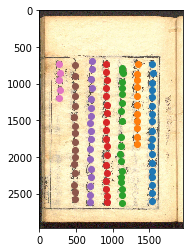

又同うるの上白米水にて何返 も能洗少程はかしはたき絹ふるひにてふる ひ水にてこね少かためにして少つゝ取ひらめ せいろうにならへよくむし申候むせ取あけ よくつき申候能つき候てつねのちまきの なりに丸め笹の葉につゝみ成程しめま き申候まきめゆるく候へはまき跡付申さす候 


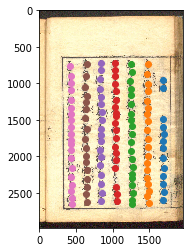

白米壱升にちまき四五拾程御座候 六十七あさいなまき上〻白餅米を水にて 一返洗椿のあくにて二時半程ひやしこしき にてむし餅に仕候へは黄色になり申候をつね のちまきのなりに仕合わらのしへにて包 又上をもしへにて常のくまき少湯煮 して遣申候 


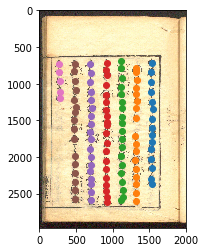

右之あくの拵様椿のはい壱斗を水 壱斗五升にてあくのすみ申程にたれ申候 へはあく壱斗弐升程御座候を八升程にせん しつめ遣申候 六十八たけなかし小むきの粉五升水にて 夏はかたくこね冬はやはらかにこね柳桶に入 夏は三日冬は十日程置候へは上にあはたちわ 


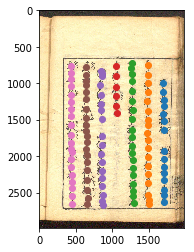

きあかり申候を少間を置候へは右のかさほと にへり申候時に上にうばはり申候を取捨 候て其内へびささきのあく弐合程入申候て又 別にむきの粉五升に白沙糖壱貫目入右之 柳桶に入ませ合一夜置あつかみのあつさ 程にのし長さ三寸はゝ一寸程に切平銅鍋 に入鍋のふたを仕上下に火を置ふくれ申候を 


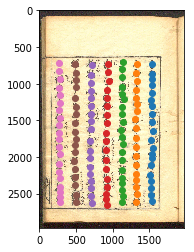

あいつにてやき申候但上の火つよく仕候 右あくのこしらへやうひさゝきのはい 五升を水八斗にてあくのすみ申候程たれ 候へはあく六斗御座候を六升に成申程にせ むし申候 六十九ふちのみとり右竹なかしの仕様と同 前に御座候あつ紙のあつさにのはし切申候時 


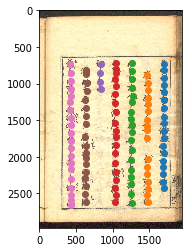

に長さ三寸幅三分程に切右のくやき申候 七十こひたゝきたうほし餅米上白を 餅にしてちいさく丸くひらめあつきを能煮 て塩少入すりつふし右之餅の上に少つゝい たゝかせ申候 七十一茶きんつゝみたうほし米右之こと くにして餅にして丸くちいさくひらめ中へあん 


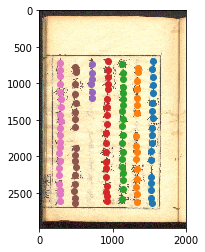

をつゝみしやきんにて物をつゝむなりに作り 上下より少やき申候 七十二へにもちうるし上白米を粉に して水にかたくこね其後かたべにを色あかく 見事に成申程つきませ壱尺四寸高さ五分 斗の箱にのしかため一夜にをきいろ〱に切申候 七十三椿餅うるし上白米を粉にして口 


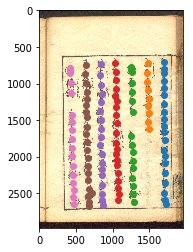

なしを水にてひたし右の粉をこねむし 右紅餅のくの箱に入のしかため一夜置 さまし切申候 七十四青米餅青米餅いねのもみつめ にてひねり見申候に本ほは白水のやうなる 水出申候中からもみは爪にたへかたまり申候 時同し比のいね斗をこきあつめもみ弐斗 


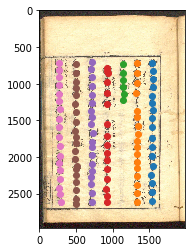

に水弐斗なへに入煮もみかたまり御座候 を大かた心得して能時分になへよりあけむし ろにうすくひろけ晴天に二三時の内ひどり 申候やうに少も天気あしく候へは青く成申 さす候木うすにてつきやき米に仕候色青 くやはらかに御座候 七十五やうかんの方あつき壱升白沙糖 


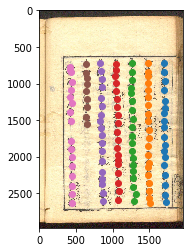

In [13]:
for idx in idx_train[200:210]:
    df_code = gen_df_code(df_train_idx, idx)
    gen_string(df_code)

    image_path = IMAGES + idx + '.jpg'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cols = df_code['col_n'].unique()
    for col in cols:
        centers = df_code.query('col_n == {}'.format(col))[['center_x','center_y']].values
        plt.scatter(centers[:,0], centers[:,1])
    plt.imshow(img)
    plt.show()

In [14]:
df_code

,char,x,y,w,h,image_id,center_x,center_y,col_n
0,U+6C34,1663,768,88,159,100249376_00038_1,1707,847,0
1,U+306B,1683,1356,49,100,100249376_00038_1,1707,1406,0
2,U+3082,1684,1679,47,115,100249376_00038_1,1707,1736,0
3,U+305F,1683,1964,59,87,100249376_00038_1,1712,2007,0
4,U+3078,1654,1292,119,88,100249376_00038_1,1713,1336,0
5,U+307F,1686,1791,48,93,100249376_00038_1,1710,1837,0
6,U+306A,1676,1178,73,113,100249376_00038_1,1712,1234,0
7,U+5FA1,1659,2321,108,131,100249376_00038_1,1713,2386,0
8,U+306B,1666,671,64,95,100249376_00038_1,1698,718,0
9,U+304B,1648,1894,104,69,100249376_00038_1,1700,1928,0


## preparation for SSD training

In [4]:
len(TRUE_FILES) + len(FALSE_FILES)

37450

In [5]:
df_raw = pd.read_csv(CSV_FOLDER+'ext_face_flg_size.csv')

In [6]:
df_pos = df_raw[df_raw['flg']==1]
df_neg = df_raw[df_raw['flg']==0]

In [7]:
def calc_loc(df):
    xsize_arr = df['xsize'].values
    ysize_arr = df['ysize'].values
    x0_arr = df['x0'].values / xsize_arr
    x1_arr = df['x1'].values / xsize_arr 
    y0_arr = df['y0'].values / ysize_arr
    y1_arr = df['y1'].values / ysize_arr
    locs = np.vstack([y0_arr, x0_arr, y1_arr, x1_arr]).T
    return locs

In [8]:
loc_pos = calc_loc(df_pos)
loc_neg = calc_loc(df_neg)

In [9]:
locs = np.vstack([loc_pos, loc_neg])

In [10]:
locs.shape

(37450, 4)

In [11]:
ohe = OneHotEncoder()
names = df_pos['name'].values.reshape(-1, 1)
label_pos = ohe.fit_transform(names).toarray()

# label_pos = np.zeros([loc_pos.shape[0], 1])
# label_pos[:, 0] = 1

label_bg_pos = np.zeros([label_pos.shape[0], 1])
label_pos = np.hstack([label_bg_pos, label_pos])

label_neg = np.zeros([loc_neg.shape[0], label_pos.shape[1]])
# label_neg[:, 0] = 1


print(label_pos.shape)
print(label_neg.shape)

(8441, 101)
(29009, 101)


In [12]:
labels = np.vstack([label_pos, label_neg])
labels.shape

(37450, 101)

In [13]:
loc_label_arr = np.hstack([locs, labels])
loc_label_arr.shape

(37450, 105)

In [14]:
def gen_file_list(df):
    fname_list = []
    files = df['file_path']
    for i, f in enumerate(files):
        fname = df['name'].values[i] + '/' + f.split('/')[-1]
        fname_list.append(fname)
    return fname_list

In [15]:
fname_list = []
fname_list_pos = gen_file_list(df_pos)
fname_list_neg = gen_file_list(df_neg)
fname_list.extend(fname_list_pos)
fname_list.extend(fname_list_neg)
len(fname_list)

37450

In [16]:
gt = {}
se = pd.Series(fname_list)
idx = se.value_counts().index
for i in idx:
    mask = se == i
    gt[i] = loc_label_arr[mask]

In [17]:
keys = gt.keys()
num = len(keys)
num_train = round(num * 0.9)
pickup = random.sample(range(num), num)
pickup_train = pickup[:num_train]
pickup_val = pickup[num_train:]
keys_train = list(np.array(list(keys))[pickup_train])
keys_val = list(np.array(list(keys))[pickup_val])

In [18]:
len(pickup_train) + len(pickup_val)

23741

## pretraining model

In [ ]:
# from keras.applications.vgg16 import VGG16
# vgg16_original = VGG16(include_top=True,
#                                weights='imagenet',
#                                input_tensor=None, 
#                                input_shape=None, 
#                                pooling=None, 
#                                classes=1000)
# vgg16_original.save_weights('vgg16_original.hdf5')

In [ ]:
NUM_CLASSES = label_pos.shape[1]
input_shape = (300, 300, 3) # (y, x, c)
variances = [0.1, 0.1, 0.2, 0.2]
model_obj = SSD_VGG16(num_classes=NUM_CLASSES, img_size=input_shape, variances=variances)

In [ ]:
model = model_obj.SSD()
for L in model.layers[:19]:
    L.trainable = False

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                multiple             1792        input[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                multiple             36928       conv1_1[1][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            multiple             0           conv1_2[1][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [ ]:
det_list = model_obj.get_detector()

In [ ]:
img_size = input_shape[:2]
priors = np.zeros(8).reshape(1,-1)
aspects = [1.0, 1.0, 2, 3, 1/2, 1/3]
for i in range(len(det_list)):
    det_grid = np.array([det_list[i].shape[1].value, det_list[i].shape[2].value])
    steps = (img_size / det_grid).astype(np.int)

    y_cent_arr = (np.linspace(steps[0]/2, img_size[0]-steps[0]/2, det_grid[0]))
    x_cent_arr = (np.linspace(steps[1]/2, img_size[1]-steps[1]/2, det_grid[1]))
    y_cent, x_cent = np.meshgrid(y_cent_arr, x_cent_arr)
    y_cent = y_cent.reshape(-1,1)
    x_cent = x_cent.reshape(-1,1)

    y_var = np.ones_like(y_cent).reshape(-1,1) * variances[0]
    x_var = np.ones_like(x_cent).reshape(-1,1) * variances[1]
    h_var = np.ones_like(y_cent).reshape(-1,1) * variances[2]
    w_var = np.ones_like(x_cent).reshape(-1,1) * variances[3]

    for asp in aspects:
        h_arr = np.ones(det_grid[0]**2).reshape(-1,1) * steps[0] * asp
        w_arr = np.ones(det_grid[1]**2).reshape(-1,1) * steps[1] / asp
        y_mins  = np.clip(y_cent - h_arr // 2, 0, img_size[0])
        x_mins  = np.clip(x_cent - h_arr // 2, 0, img_size[1])
        y_maxs  = np.clip(y_cent + h_arr // 2, 0, img_size[0])
        x_maxs = np.clip(x_cent + w_arr // 2, 0, img_size[1])
        priors_pos = np.hstack([y_mins, x_mins, y_maxs, x_maxs])
        priors_var = np.hstack([y_var, x_var, h_var, w_var])
        priors_dum = np.hstack([priors_pos, priors_var])
        priors = np.vstack([priors, priors_dum])

priors = priors[1:]
priors[:, 0] = priors[:, 0] / img_size[0]
priors[:, 1] = priors[:, 1] / img_size[1]
priors[:, 2] = priors[:, 2] / img_size[0]
priors[:, 3] = priors[:, 3] / img_size[1]
priors.shape #(4*4*6, 8)

(804, 8)

In [ ]:
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [ ]:
batch_size = 16
gen = Generator(gt, bbox_util, batch_size, SCR_FOLDER,
                keys_train, keys_val,
                input_shape, do_crop=True)

In [ ]:
base_lr = 0.01
adm = keras.optimizers.Adam(lr=base_lr)
model.compile(optimizer=adm,
              loss=MultiboxLoss(NUM_CLASSES, alpha=1.0).compute_loss)

In [ ]:
epochs = 100
history = model.fit_generator(gen.generate(True), 
                              steps_per_epoch=(len(keys_train)//batch_size) // 2, 
                              verbose=1,
                              epochs=epochs,
                              validation_data=gen.generate(False),
                              validation_steps=(len(keys_val)//batch_size)) // 2

/home/ryoji/Documents/python/rec_act/scrape/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
 84/667 [==>...........................] - ETA: 4:21 - loss: 7.2625

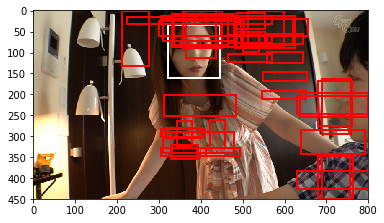

In [29]:
# j = 1693
j = 2212
img_path = SCR_FOLDER + fname_list[j]
img = image.load_img(img_path, target_size=input_shape[:2])
img = image.img_to_array(img)
x = img.reshape((-1,)+input_shape) / 255
y_pred = model.predict(x) 
# (sample, defaultbox, (4(output: cy, cx, h, w), 2(num_class), 8(default box: ymin, xmin, ymax, xmax, varyc, varxc, varh, varw)))
results = bbox_util.detection_out(y_pred, confidence_threshold=0.001)

img = image.load_img(img_path)
img = image.img_to_array(img)

gt_ = gt[fname_list[j]]
det_ymin = gt_[:, 0]
det_xmin = gt_[:, 1]
det_ymax = gt_[:, 2]
det_xmax = gt_[:, 3]

plt.imshow(img / 255.)
currentAxis = plt.gca()
for i in range(len(gt_)):
    ymin = int(round(det_ymin[i] * img.shape[0]))
    xmin = int(round(det_xmin[i] * img.shape[1]))
    ymax = int(round(det_ymax[i] * img.shape[0]))
    xmax = int(round(det_xmax[i] * img.shape[1]))

    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1

    currentAxis.add_patch(plt.Rectangle(*coords, fill=False,  edgecolor='white', linewidth=2))

det_label = results[0][:, 0]
det_conf = results[0][:, 1]
det_ymin = results[0][:, 2]
det_xmin = results[0][:, 3]
det_ymax = results[0][:, 4]
det_xmax = results[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.007]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_ymin = det_ymin[top_indices]
top_xmin = det_xmin[top_indices]
top_ymax = det_ymax[top_indices]
top_xmax = det_xmax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

plt.imshow(img / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    display_txt = '{:0.2f}, {}'.format(score, label)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[0]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
#     currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()

In [ ]:
det_conf

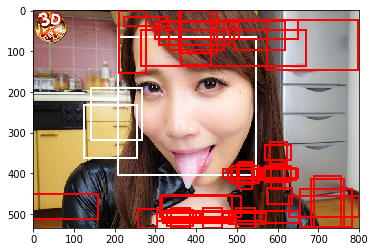

In [36]:
# j = 1693
j = 2634
img_path = SCR_FOLDER + fname_list[j]
img = image.load_img(img_path, target_size=input_shape[:2])
img = image.img_to_array(img)
x = img.reshape((-1,)+input_shape) / 255
y_pred = model.predict(x) 
# (sample, defaultbox, (4(output: cy, cx, h, w), 2(num_class), 8(default box: ymin, xmin, ymax, xmax, varyc, varxc, varh, varw)))
results = bbox_util.detection_out(y_pred, confidence_threshold=0.001)

img = image.load_img(img_path)
img = image.img_to_array(img)

gt_ = gt[fname_list[j]]
det_ymin = gt_[:, 0]
det_xmin = gt_[:, 1]
det_ymax = gt_[:, 2]
det_xmax = gt_[:, 3]

plt.imshow(img / 255.)
currentAxis = plt.gca()
for i in range(len(gt_)):
    ymin = int(round(det_ymin[i] * img.shape[0]))
    xmin = int(round(det_xmin[i] * img.shape[1]))
    ymax = int(round(det_ymax[i] * img.shape[0]))
    xmax = int(round(det_xmax[i] * img.shape[1]))

    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1

    currentAxis.add_patch(plt.Rectangle(*coords, fill=False,  edgecolor='white', linewidth=2))

det_label = results[0][:, 0]
det_conf = results[0][:, 1]
det_ymin = results[0][:, 2]
det_xmin = results[0][:, 3]
det_ymax = results[0][:, 4]
det_xmax = results[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.006]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_ymin = det_ymin[top_indices]
top_xmin = det_xmin[top_indices]
top_ymax = det_ymax[top_indices]
top_xmax = det_xmax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

plt.imshow(img / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    display_txt = '{:0.2f}, {}'.format(score, label)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[0]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
#     currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()